# FPGheArt - Week 2 exercise

### Lorenzo Buriola - 2021860
### Filippo Conforto - 2021856
### Lorenzo Domenichetti - 2011653


(IBM says these colors are good also for color blinds. We hope so!)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD 
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import time

### Data (strings) and splitting

In [2]:
fname="DATA/sequences16.csv"
sx, sy = np.loadtxt(fname,delimiter=',',
                   usecols= (0,1), unpack=True, dtype = str)

In [3]:
N = len(sy)
print(f"Number of total samples {N}")
Ls = len(sx[0])
print(f"Lenght of a sample {Ls}")

print(f"Sample: {sx[0]}, label: {sy[0]}")

perc_train = 0.8
N_train = int(N*perc_train)
N_test = N -N_train
print(f'\ndata:{N}\ntrain: {N_train}\ntest: {N_test}')

Number of total samples 3000
Lenght of a sample 16
Sample: AAGGTCTGCCGGCCGA, label: 1

data:3000
train: 2400
test: 600


In [4]:
Q = ['A', 'C', 'G', 'T']
Nc=4
onehc = {Q[i]: i for i in range(Nc)}
print(f"One-hot encoding dictionary: {onehc}")

One-hot encoding dictionary: {'A': 0, 'C': 1, 'G': 2, 'T': 3}


### Data conversion: One-Hot Encoding



In [5]:
y = sy.astype(int)

L = Ls*Nc
print(f"Product of lenght ({Ls}) and character possibilities ({Nc}): {L}\n")

x= np.zeros((N,L))

for n in range(N):
    for i in range(Ls):
        x[n][i*4 + onehc[sx[n][i]]] = 1
print(f"Original sequence:\n {sx[0]}\n")
print(f"Encoded sequence:\n {x[0]}")

Product of lenght (16) and character possibilities (4): 64

Original sequence:
 AAGGTCTGCCGGCCGA

Encoded sequence:
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]


### Split train/test - validation

In [6]:
(x_train, y_train) = (x[:N_train], y[:N_train])
(x_test, y_test) = (x[N_train:], y[N_train:])
print(f"Ratio between y_train labels sum and train samples: {y_train.sum() / N_train}")
print(f"Ratio between y_test  labels sum and test samples: {y_test.sum() / N_test}")


Ratio between y_train labels sum and train samples: 0.24333333333333335
Ratio between y_test  labels sum and test samples: 0.25833333333333336


### Definition of model in Keras

In [7]:
np.random.seed(123)

model = Sequential()

model.add(Dense(L,input_shape=(L,),activation = "relu"))
model.add(Dense(L/2,activation = "relu"))
model.add(Dense(L/4,activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1,activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics= ["accuracy"])

In [9]:
fit = model.fit(x_train, y_train,
                epochs=30, batch_size = 50, validation_data = (x_test,y_test), shuffle = True, verbose = 0)

Final Test loss: 1.1024367809295654
Final Test accuracy: 0.7683333158493042


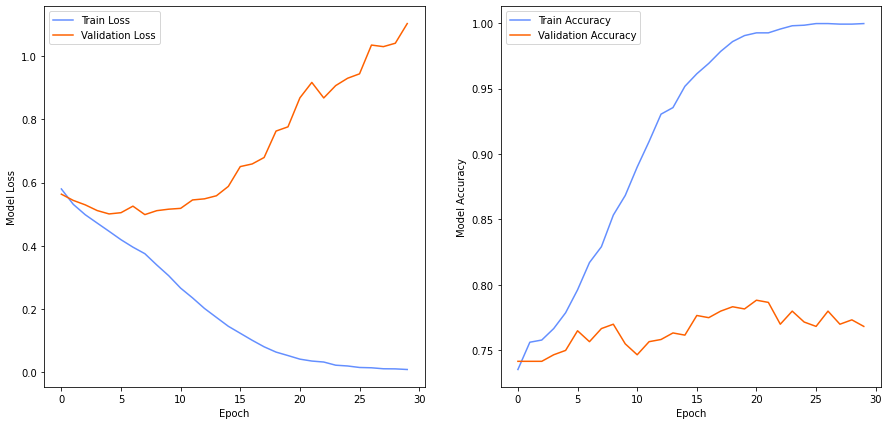

In [10]:
# evaluate model
score = model.evaluate(x_test, y_test, verbose=0)

# print performance
print('Final Test loss:', score[0])
print('Final Test accuracy:', score[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))


# summarize history for loss
ax1.plot(fit.history['loss'], label = 'Train Loss', color = '#648FFF')
ax1.plot(fit.history['val_loss'], label = 'Validation Loss', color = '#FE6100')

ax1.legend(loc = 'best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Model Loss')


# summarize history for accuracy
ax2.plot(fit.history['accuracy'], label = 'Train Accuracy', color =  '#648FFF')
ax2.plot(fit.history['val_accuracy'], label = 'Validation Accuracy', color = '#FE6100')

ax2.legend(loc = 'best')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Model Accuracy')

plt.show()

## Data augmentation

In this chapter we try to reshuffle randomly the bases in the sequences keeping the labels constant. 

We are aware of the fact that, in doing so, we introduce some noise as the key for labelling may be in certain cases lost during the reshuffle. Anyhow, given the huge increase in the test samples (15 times), we hope to achieve a better score on the test set.

The discussion on whether one or the other effect is higher is done comparing the results at the end of this section.

In [11]:
#data augementation trough shuffling. Every 16 combiations are tried for each sequence
augval = np.asarray([[[v[-i:] + v[:-i],vy] for i in range(16)] for v,vy in zip(sx[:N_train],y[:N_train])]).reshape(38400,2)
augsx = augval[:,0]
augy_train = augval[:,1].astype(int)

In [12]:
#One-Hot encoding for the augmented sequences
augx_train = np.zeros((N_train*16,L))

for n in range(N_train*16):
    for i in range(Ls):
        augx_train[n][i*4 + onehc[augsx[n][i]]] = 1
aug_N_train = N_train*16

### Split train/test - validation

In [13]:
#ModelFit with Augmented Data
fit_augmented = model.fit(augx_train, augy_train,
                epochs=30, batch_size = 50, validation_data = (x_test,y_test), shuffle = True, verbose = 0)


19/19 [==============================] - 0s 2ms/step - loss: 0.2881 - accuracy: 0.8867

Test loss: 0.28808557987213135
Test accuracy: 0.8866666555404663


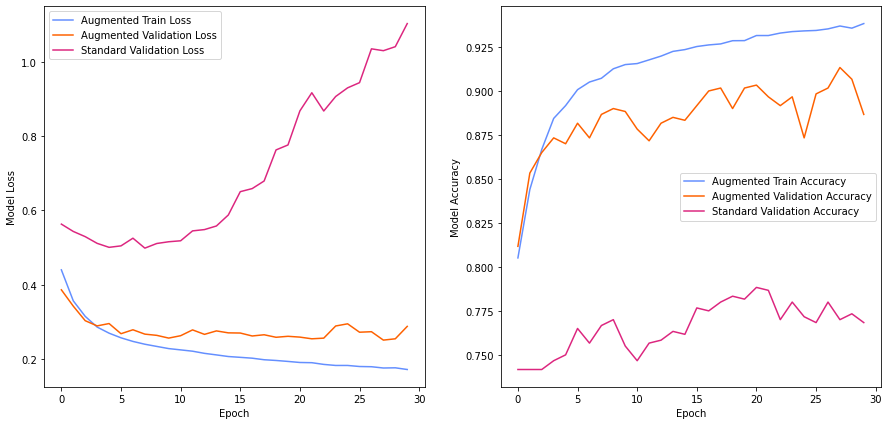

In [14]:
# evaluate model
score = model.evaluate(x_test, y_test, verbose=0)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# looking training history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))


# summarize history for loss
ax1.plot(fit_augmented.history['loss'], label = 'Augmented Train Loss',color =  '#648FFF')
ax1.plot(fit_augmented.history['val_loss'], label = 'Augmented Validation Loss', color = '#FE6100')
ax1.plot(fit.history['val_loss'], label = 'Standard Validation Loss', color  = '#DC267F' )

ax1.legend(loc = 'best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Model Loss')


# summarize history for accuracy
ax2.plot(fit_augmented.history['accuracy'], label = 'Augmented Train Accuracy', color =  '#648FFF')
ax2.plot(fit_augmented.history['val_accuracy'], label = 'Augmented Validation Accuracy',color = '#FE6100')
ax2.plot(fit.history['val_accuracy'], label = 'Standard Validation Accuracy', color  = '#DC267F')


ax2.legend(loc = 'best')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Model Accuracy')

plt.show()

Even with the randomization introduced, the network provides better results than the previous case. In fact, the validation accuracy is higher than before, while the loss also diminishes. 

Moreover, using more data we prevent the overfitting for a large number of epochs, as we can see in the plot. This ensures the network to continue learning trough different epochs, so increasing the validation accuracy.

## GridSearch for parameter optimization

In the following, we define a GridSearch method for finding the best parameters to fed into the network. 
A cell is entirely commented, as it runs about 500 minimizations (about 30min CPU/GPU time).
Results are provided as an imported csv file. 

In [15]:
def create_DNN(activation, dropout_rate,layers):
    model = Sequential()

    model.add(Dense(L,input_shape=(L,),activation = activation))
    for i in range(len(layers)):
        model.add(Dense(layers[i],activation = activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation="sigmoid"))
    return model


In [16]:
def compile_model(optimizer=keras.optimizers.Adam(), activation = "relu", dropout_rate = 0.2, layers = (L/2, L/4)):
    # create the mode
    model=create_DNN(activation, dropout_rate, layers)
    # compile the model
    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model


# WARNING!!!

The cell below starts a quite heavy GridSearch. It takes abous 30min to finish the hole search. 
We report below the (fortunately) saved results we get after running with the shown parameters.

In [ ]:
# # call Keras scikit wrapper
# model_gridsearch = KerasClassifier(build_fn = compile_model)

# # list of allowed optional arguments for the optimizer, see `compile_model()`
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# # define parameter dictionary
# param_grid = dict(optimizer=optimizer, activation = activation, dropout_rate=dropout_rate)
# # call scikit grid search module
# grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
# grid_result = grid.fit(x_train,y_train, epochs=30, batch_size = 50, shuffle = True)


In [68]:
df_GridSearch = pd.read_csv("DATA/GridSearch_results.csv", index_col = False)
df_GridSearch = df_GridSearch.iloc[:,1:]
df_GridSearch.sort_values(by = "rank_test_score", ascending = True)
df_GridSearch

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_dropout_rate,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,1.744381,0.285944,0.156408,0.024191,softmax,0.0,SGD,"{'activation': 'softmax', 'dropout_rate': 0.0,...",0.768333,0.743333,0.766667,0.748333,0.756667,0.010992,276
1,1.683135,0.014039,0.144131,0.002644,softmax,0.0,RMSprop,"{'activation': 'softmax', 'dropout_rate': 0.0,...",0.768333,0.743333,0.766667,0.748333,0.756667,0.010992,276
2,1.585771,0.185988,0.149712,0.002874,softmax,0.0,Adagrad,"{'activation': 'softmax', 'dropout_rate': 0.0,...",0.768333,0.256667,0.766667,0.748333,0.635000,0.218572,484
3,1.715497,0.206373,0.176459,0.028340,softmax,0.0,Adadelta,"{'activation': 'softmax', 'dropout_rate': 0.0,...",0.768333,0.743333,0.766667,0.748333,0.756667,0.010992,276
4,1.809999,0.253402,0.154890,0.020702,softmax,0.0,Adam,"{'activation': 'softmax', 'dropout_rate': 0.0,...",0.768333,0.743333,0.766667,0.748333,0.756667,0.010992,276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,0.922601,0.006654,0.083078,0.001907,linear,0.9,Adagrad,"{'activation': 'linear', 'dropout_rate': 0.9, ...",0.768333,0.746667,0.768333,0.746667,0.757500,0.010833,266
556,1.012483,0.068138,0.090344,0.008606,linear,0.9,Adadelta,"{'activation': 'linear', 'dropout_rate': 0.9, ...",0.578333,0.568333,0.410000,0.601667,0.539583,0.075786,529
557,1.124401,0.091408,0.143794,0.098108,linear,0.9,Adam,"{'activation': 'linear', 'dropout_rate': 0.9, ...",0.783333,0.753333,0.771667,0.763333,0.767917,0.011016,154
558,0.996102,0.032718,0.093340,0.009601,linear,0.9,Adamax,"{'activation': 'linear', 'dropout_rate': 0.9, ...",0.780000,0.743333,0.765000,0.771667,0.765000,0.013591,206


In [69]:
df_GridSearch[df_GridSearch["rank_test_score"] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_dropout_rate,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
249,1.066452,0.008873,0.083023,0.000802,relu,0.5,Adam,"{'activation': 'relu', 'dropout_rate': 0.5, 'o...",0.805,0.793333,0.801667,0.808333,0.802083,0.005575,1


The best output is given using Adam, a 0.5 dropout rate on the third layer and "ReLU" as activation function

## Rescaling Data

In these section we investigate what happens rescaling data to a null average. In particular, for OneHotEncoded samples, we replace 1s with 0.75 and 0s with -0.25, so that the total average is zero for every base. 

We exploit as starting data the augmented ones, as the network proves to be more effective when trained on a larger set.

In [17]:
augx_train_c = augx_train.copy()
augx_train_c[augx_train_c==0]=-0.25
augx_train_c[augx_train_c==1]=0.75
x_test_c = x_test.copy()
x_test_c[x_test_c==0]=-0.25
x_test_c[x_test_c==1]=0.75
print(augx_train_c) #augmented and rescaled training set

[[ 0.75 -0.25 -0.25 ... -0.25 -0.25 -0.25]
 [ 0.75 -0.25 -0.25 ... -0.25  0.75 -0.25]
 [-0.25 -0.25  0.75 ...  0.75 -0.25 -0.25]
 ...
 [-0.25 -0.25 -0.25 ... -0.25 -0.25 -0.25]
 [ 0.75 -0.25 -0.25 ... -0.25 -0.25  0.75]
 [-0.25 -0.25 -0.25 ... -0.25 -0.25  0.75]]


In [18]:
#_c stands for "centered"
fit_c = model.fit(augx_train_c, augy_train,
                epochs=30, batch_size = 50, validation_data = (x_test_c, y_test), shuffle = True, verbose = 0)


Final Test loss: 2.2908082008361816
Final Test accuracy: 0.7316666841506958


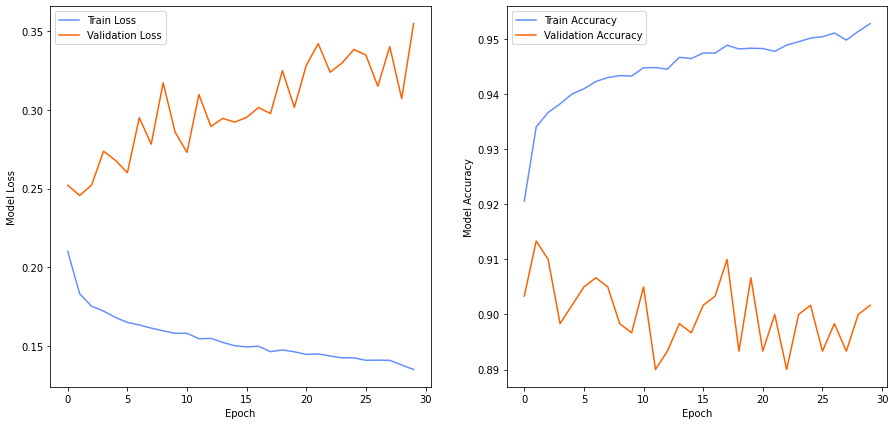

In [20]:
# evaluate model
score = model.evaluate(x_test, y_test, verbose=0)

# print performance
print('Final Test loss:', score[0])
print('Final Test accuracy:', score[1])

# look into training history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))


# summarize history for loss
ax1.plot(fit_c.history['loss'], label = 'Train Loss', color = '#648FFF')
ax1.plot(fit_c.history['val_loss'], label = 'Validation Loss', color = '#FE6100')

ax1.legend(loc = 'best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Model Loss')


# summarize history for accuracy
ax2.plot(fit_c.history['accuracy'], label = 'Train Accuracy', color =  '#648FFF')
ax2.plot(fit_c.history['val_accuracy'], label = 'Validation Accuracy', color = '#FE6100')

ax2.legend(loc = 'best')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Model Accuracy')

plt.show()

Centering the data does not change the final accuracy significantly.

## Try: Data Uniformity

In the following sections we try to explore whether some bases have more likely a certain position. This would help us avoid using any columns in the following analysis, as they would not provide any additional piece of information. 
(Similar idea to a PCA analysis) 

Anyhow, all data seem to have a uniform pattern troughout all the 16 possible positions.

In [76]:
df = pd.DataFrame([list(s) for s in sx])

In [77]:
df.loc["3000_Acount"] = df[df == 'A'].count(axis = 0)/3000
df.loc["3001_Ccount"] = df[df == 'C'].count(axis = 0)/3000
df.loc["3002_Tcount"] = df[df == 'T'].count(axis = 0)/3000
df.loc["3003_Gcount"] = df[df == 'G'].count(axis = 0)/3000
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,A,A,G,G,T,C,T,G,C,C,G,G,C,C,G,A
1,C,C,T,C,C,C,T,T,A,T,G,G,G,G,G,A
2,T,C,T,C,T,C,G,G,A,A,C,T,G,T,C,A
3,G,T,T,A,A,A,C,G,T,T,A,C,A,T,C,T
4,T,T,A,A,A,T,G,C,T,G,C,T,G,A,T,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,C,G,A,T,T,G,A,A,G,T,G,T,A,C,G,A
3000_Acount,0.263,0.246667,0.255,0.246333,0.247,0.246,0.243,0.256667,0.251,0.249333,0.248667,0.254,0.244,0.258333,0.25,0.250333
3001_Ccount,0.237,0.260667,0.253,0.249,0.242,0.253333,0.257333,0.239667,0.254,0.248,0.253333,0.238,0.265,0.253667,0.254667,0.248333
3002_Tcount,0.246333,0.242,0.236667,0.251667,0.261667,0.25,0.255333,0.252333,0.250333,0.237333,0.255333,0.252,0.252,0.235,0.247667,0.241


## 15 DNA bases

Let's try to reduce the noise considering the physical properties of bases. 

**Nitrogen triplets** are the building blocks of proteins. A sequence of 16 bases contains only 5 triplets, as a base is not unpaired. 

Augmented and original data will be considered.

We will then reduce the treatment to 15 bases at a time. In the former case, we won't consider the last base in our sequences, in the latter the first one. 

In order to then augment the data, **we only shuffle triplets among themselves**, and not single bases.

In [21]:
x15 = x[:,:-4] #cutting last base from each OneHot sample
(x_train15r, y_train) = (x15[:N_train], y[:N_train])
(x_test15r, y_test) = (x15[N_train:], y[N_train:])

np.random.seed(123)
# given by numb of bases (15) times type of bases (4, for oneHotencoding)
L = 60 

#Keras model definition
model = Sequential()

model.add(Dense(L,input_shape=(L,),activation = "relu"))
model.add(Dense(L/2,activation = "relu"))
model.add(Dense(L/4,activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))

# model.summary()

model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics= ["accuracy"])

fit_15_cutright = model.fit(x_train15r, y_train,
                epochs=30, batch_size = 50, validation_data = (x_test15r,y_test), shuffle = True, verbose = 0)

Final Test loss: 1.0278587341308594
Final Test accuracy: 0.7583333253860474


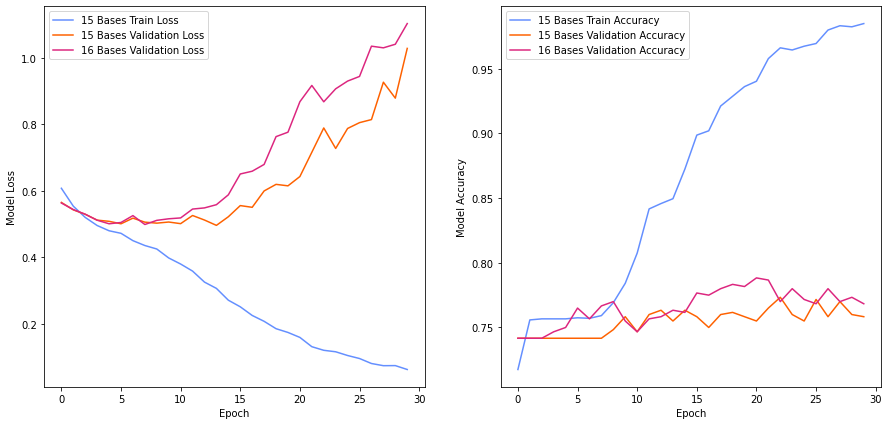

In [22]:
# evaluate model
score = model.evaluate(x_test15r, y_test, verbose=0)

# print performance
print('Final Test loss:', score[0])
print('Final Test accuracy:', score[1])

# look into training history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))


# summarize history for loss
ax1.plot(fit_15_cutright.history['loss'], label = '15 Bases Train Loss',color =  '#648FFF')
ax1.plot(fit_15_cutright.history['val_loss'], label = '15 Bases Validation Loss', color = '#FE6100')
ax1.plot(fit.history['val_loss'], label = '16 Bases Validation Loss', color  = '#DC267F' )

ax1.legend(loc = 'best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Model Loss')


# summarize history for accuracy
ax2.plot(fit_15_cutright.history['accuracy'], label = '15 Bases Train Accuracy', color =  '#648FFF')
ax2.plot(fit_15_cutright.history['val_accuracy'], label = '15 Bases Validation Accuracy',color = '#FE6100')
ax2.plot(fit.history['val_accuracy'], label = '16 Bases Validation Accuracy', color  = '#DC267F')


ax2.legend(loc = 'best')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Model Accuracy')

plt.show()

Unexpectedly, we notice that discarding the last base we get very similar results with respect to the first case, in which we did consider all the bases. 

In principle, it means no much information is contained in the very last base. Let's test the network behaviour with augmented data

In [23]:
sx15 = [n[:-1] for n in sx]
augval15 = np.asarray([[[v[-i:] + v[:-i],vy] for i in range(0, 15, 3)] for v,vy in zip(sx15[:N_train],y[:N_train])]).reshape(12000,2)
augsx15 = augval15[:,0]
augy_train15 = augval15[:,1].astype(int)


#Showing a sample, with the shuffle of the five triplets contained in the sequence
print(augval15[:5])

[['AAGGTCTGCCGGCCG' '1']
 ['CCGAAGGTCTGCCGG' '1']
 ['CGGCCGAAGGTCTGC' '1']
 ['TGCCGGCCGAAGGTC' '1']
 ['GTCTGCCGGCCGAAG' '1']]


In [24]:
augx_train15 = np.zeros((N_train*5,L))

for n in range(N_train*5):
    for i in range(15):
        augx_train15[n][i*4 + onehc[augsx15[n][i]]] = 1
aug_N_train = N_train*5

print(f"Augmented train data, shuffled triplets shape: {augx_train15.shape}")

Augmented train data, shuffled triplets shape: (12000, 60)


In [25]:
fit_aug_cutright15 = model.fit(augx_train15, augy_train15,
                epochs=30, batch_size = 50, validation_data = (x_test15r,y_test), shuffle = True, verbose = 0)

Final Test loss: 0.5358273983001709
Final Test accuracy: 0.8383333086967468


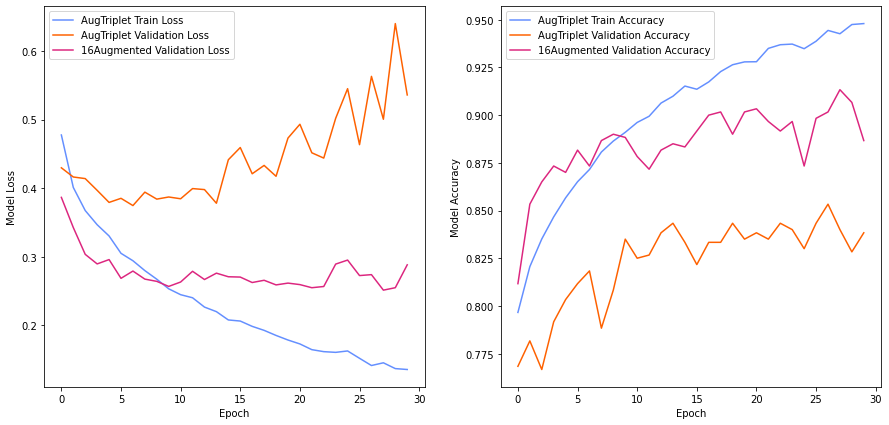

In [28]:
# evaluate model
score = model.evaluate(x_test15r, y_test, verbose=0)

# print performance
print('Final Test loss:', score[0])
print('Final Test accuracy:', score[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))


# summarize history for loss
ax1.plot(fit_aug_cutright15.history['loss'], label = 'AugTriplet Train Loss',color =  '#648FFF')
ax1.plot(fit_aug_cutright15.history['val_loss'], label = 'AugTriplet Validation Loss', color = '#FE6100')
ax1.plot(fit_augmented.history['val_loss'], label = '16Augmented Validation Loss', color  = '#DC267F' )

ax1.legend(loc = 'best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Model Loss')


# summarize history for accuracy
ax2.plot(fit_aug_cutright15.history['accuracy'], label = 'AugTriplet Train Accuracy', color =  '#648FFF')
ax2.plot(fit_aug_cutright15.history['val_accuracy'], label = 'AugTriplet Validation Accuracy',color = '#FE6100')
ax2.plot(fit_augmented.history['val_accuracy'], label = '16Augmented Validation Accuracy', color  = '#DC267F')


ax2.legend(loc = 'best')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Model Accuracy')

plt.show()

As shown, the *Augmented Random* data still outperform the 15 *Augmented Triplet* ones. 

The network may still find more useful to have more data available. 

# CASE FIRST DROP

Final Test loss: 0.941650927066803
Final Test accuracy: 0.7866666913032532


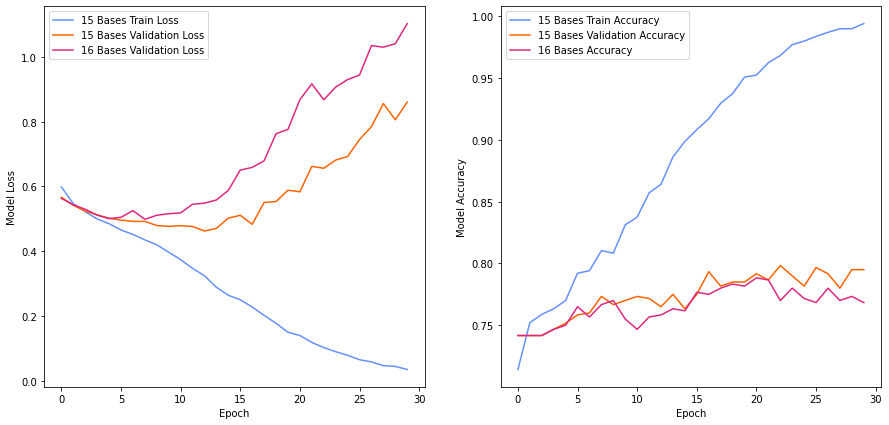

In [30]:
x15 = x[:,4:] #cutting last base from each OneHot sample
(x_train15l, y_train) = (x15[:N_train], y[:N_train])
(x_test15l, y_test) = (x15[N_train:], y[N_train:])

np.random.seed(123)
# given by numb of bases (15) times type of bases (4, for oneHotencoding)
L = 60 

#Keras model definition
model = Sequential()

model.add(Dense(L,input_shape=(L,),activation = "relu"))
model.add(Dense(L/2,activation = "relu"))
model.add(Dense(L/4,activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))

# model.summary()

model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics= ["accuracy"])

fit_15_cutleft = model.fit(x_train15l, y_train,
                epochs=30, batch_size = 50, validation_data = (x_test15l,y_test), shuffle = True, verbose = 0)

# evaluate model
score = model.evaluate(x_test15r, y_test, verbose=0)

# print performance
print('Final Test loss:', score[0])
print('Final Test accuracy:', score[1])

# look into training history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))


# summarize history for loss
ax1.plot(fit_15_cutleft.history['loss'], label = '15 Bases Train Loss',color =  '#648FFF')
ax1.plot(fit_15_cutleft.history['val_loss'], label = '15 Bases Validation Loss', color = '#FE6100')
ax1.plot(fit.history['val_loss'], label = '16 Bases Validation Loss', color  = '#DC267F' )

ax1.legend(loc = 'best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Model Loss')


# summarize history for accuracy
ax2.plot(fit_15_cutleft.history['accuracy'], label = '15 Bases Train Accuracy', color =  '#648FFF')
ax2.plot(fit_15_cutleft.history['val_accuracy'], label = '15 Bases Validation Accuracy',color = '#FE6100')
ax2.plot(fit.history['val_accuracy'], label = '16 Bases Accuracy', color  = '#DC267F')


ax2.legend(loc = 'best')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Model Accuracy')

plt.show()

Augmented train data, shuffled triplets shape: (12000, 60)
Final Test loss: 1.1852654218673706
Final Test accuracy: 0.8550000190734863


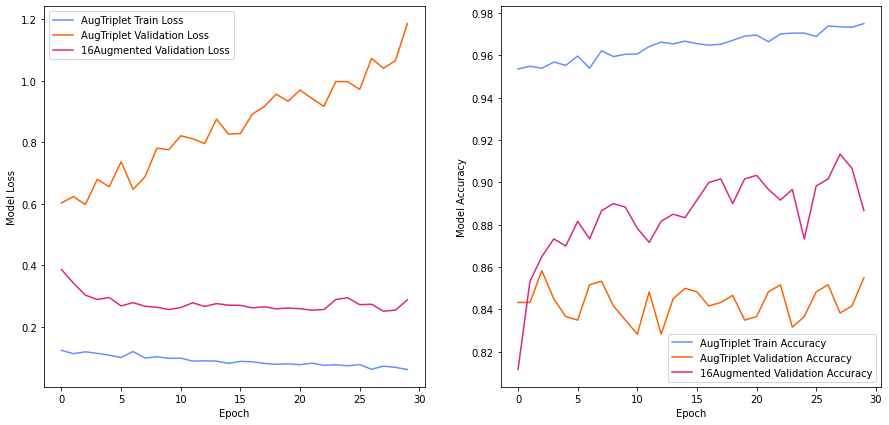

In [32]:
sx15Left = [n[1:] for n in sx]
augval15 = np.asarray([[[v[-i:] + v[:-i],vy] for i in range(0, 15, 3)] for v,vy in zip(sx15Left[:N_train],y[:N_train])]).reshape(12000,2)
augsx15 = augval15[:,0]
augy_train15 = augval15[:,1].astype(int)

augsx15

augx_train15 = np.zeros((N_train*5,L))
for n in range(N_train*5):
    for i in range(15):
        augx_train15[n][i*4 + onehc[augsx15[n][i]]] = 1
aug_N_train = N_train*5

print(f"Augmented train data, shuffled triplets shape: {augx_train15.shape}")

fit_aug_cutright15 = model.fit(augx_train15, augy_train15,
                epochs=30, batch_size = 50, validation_data = (x_test15r,y_test), shuffle = True, verbose = 0)

# evaluate model
score = model.evaluate(x_test15r, y_test, verbose=0)

# print performance
print('Final Test loss:', score[0])
print('Final Test accuracy:', score[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))


# summarize history for loss
ax1.plot(fit_aug_cutright15.history['loss'], label = 'AugTriplet Train Loss',color =  '#648FFF')
ax1.plot(fit_aug_cutright15.history['val_loss'], label = 'AugTriplet Validation Loss', color = '#FE6100')
ax1.plot(fit_augmented.history['val_loss'], label = '16Augmented Validation Loss', color  = '#DC267F' )

ax1.legend(loc = 'best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Model Loss')


# summarize history for accuracy
ax2.plot(fit_aug_cutright15.history['accuracy'], label = 'AugTriplet Train Accuracy', color =  '#648FFF')
ax2.plot(fit_aug_cutright15.history['val_accuracy'], label = 'AugTriplet Validation Accuracy',color = '#FE6100')
ax2.plot(fit_augmented.history['val_accuracy'], label = '16Augmented Validation Accuracy', color  = '#DC267F')


ax2.legend(loc = 'best')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Model Accuracy')

plt.show()

In the Drop-First case, we achieve a similar result w.r.t. what we got in the case of random shuffling, with a third of the training samples. Accuracy in particular is close in both cases.

# Conclusion

The simplest model with the raw data gives a good result (Accuracy = 0.79). As seen, perfomances may improve using  data augmentation. In this specific case the advantages overtake the issues related to incorrect labelling - the accuracy rises up to 0.89.

The best model resulting from a Gridsearch uses *adam* as optimizer, 0.5 as dropout rate and *ReLU* as activation function. 

Data centering also does not give any improvement to the test accuracy. 

As the physical information is contained in triplets one can drop the first or the last base in the sequences, considering only five triplets. Data augmentation can be obtained in this case by shifting triplets. Nevertheless this approach does not provide an improvement compared with the previous augmentation. So, even if this approach may reduce incorrect labelling, a greater number of data yields better results. Moreover, there is no guarantee that the labelling rule depends on the considered triplets alone.

# Appendix

## Layers Dimension Optimization



To get better result we can optimize the layer size, by decreasing the number of total nodes. 

### Definition of model in Keras

In [94]:
# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn = compile_model)

# # define parameter dictionary
layers= [(L/2,), (L/4,), (L/8,), (L/8,L/16), (L/16, L/8),
         (L/32, L/16), (L/16, L/32), (L/32, L/32), (L/16, L/16)
         ,(L/8, L/8), (L/2,L/4), (L/2,L/2), (L/4,L/2), (L/4,L/8), 
         (L/8,L/4), (L/4, L/4), (L/8,L/16,L/16), (L/16, L/8,L/8),
         (L/32, L/16, L/32), (L/16, L/32, L/16)]
dropout_rate = [0.5]
param_grid = dict(layers=layers, dropout_rate =dropout_rate)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train, epochs=30, batch_size = 50, shuffle = True)


Epoch 1/30
36/36 [==============================] - 1s 2ms/step - loss: 0.6746 - accuracy: 0.5925
Epoch 2/30
36/36 [==============================] - 0s 2ms/step - loss: 0.5605 - accuracy: 0.7614
Epoch 3/30
36/36 [==============================] - 0s 2ms/step - loss: 0.5851 - accuracy: 0.7331
Epoch 4/30
36/36 [==============================] - 0s 2ms/step - loss: 0.5322 - accuracy: 0.7487
Epoch 5/30
36/36 [==============================] - 0s 2ms/step - loss: 0.5029 - accuracy: 0.7596
Epoch 6/30
36/36 [==============================] - 0s 2ms/step - loss: 0.4918 - accuracy: 0.7486
Epoch 7/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4834 - accuracy: 0.7646
Epoch 8/30
36/36 [==============================] - 0s 2ms/step - loss: 0.4670 - accuracy: 0.7777
Epoch 9/30
36/36 [==============================] - 0s 2ms/step - loss: 0.4597 - accuracy: 0.7801
Epoch 10/30
36/36 [==============================] - 0s 2ms/step - loss: 0.4385 - accuracy: 0.7908
Epoch 11/30
36/36 [

36/36 [==============================] - 0s 1ms/step - loss: 0.0624 - accuracy: 0.9857
Epoch 23/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0612 - accuracy: 0.9791
Epoch 24/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0472 - accuracy: 0.9876
Epoch 25/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0389 - accuracy: 0.9919
Epoch 26/30
36/36 [==============================] - 0s 992us/step - loss: 0.0327 - accuracy: 0.9935
Epoch 27/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0310 - accuracy: 0.9935
Epoch 28/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0322 - accuracy: 0.9952
Epoch 29/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0242 - accuracy: 0.9986
Epoch 30/30
19/19 [==============================] - 0s 1ms/step - loss: 0.7551 - accuracy: 0.7917
Epoch 1/30
36/36 [==============================] - 0s 1ms/step - loss: 0.6038 - accuracy: 0.7038
Epoch 2/30
36/36 [===

36/36 [==============================] - 0s 1ms/step - loss: 0.3410 - accuracy: 0.8475
Epoch 13/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3087 - accuracy: 0.8601
Epoch 14/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2923 - accuracy: 0.8847
Epoch 15/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2713 - accuracy: 0.8802
Epoch 16/30
36/36 [==============================] - 0s 2ms/step - loss: 0.2243 - accuracy: 0.9135
Epoch 17/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2299 - accuracy: 0.9189
Epoch 18/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2175 - accuracy: 0.9121
Epoch 19/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1867 - accuracy: 0.9257
Epoch 20/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1864 - accuracy: 0.9190
Epoch 21/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1632 - accuracy: 0.9482
Epoch 22/30
36/36 [===

36/36 [==============================] - 0s 1ms/step - loss: 0.5409 - accuracy: 0.7520
Epoch 3/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5452 - accuracy: 0.7378
Epoch 4/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5012 - accuracy: 0.7473
Epoch 5/30
36/36 [==============================] - 0s 953us/step - loss: 0.4966 - accuracy: 0.7484
Epoch 6/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4743 - accuracy: 0.7484
Epoch 7/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4929 - accuracy: 0.7349
Epoch 8/30
36/36 [==============================] - 0s 974us/step - loss: 0.4708 - accuracy: 0.7628
Epoch 9/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4463 - accuracy: 0.7603
Epoch 10/30
36/36 [==============================] - 0s 988us/step - loss: 0.4302 - accuracy: 0.7724
Epoch 11/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4342 - accuracy: 0.7617
Epoch 12/30
36/36 [====

36/36 [==============================] - 0s 1ms/step - loss: 0.1904 - accuracy: 0.9372
Epoch 23/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1730 - accuracy: 0.9374
Epoch 24/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1898 - accuracy: 0.9348
Epoch 25/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1636 - accuracy: 0.9515
Epoch 26/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1638 - accuracy: 0.9585
Epoch 27/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1533 - accuracy: 0.9585
Epoch 28/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1403 - accuracy: 0.9615
Epoch 29/30
36/36 [==============================] - 0s 991us/step - loss: 0.1366 - accuracy: 0.9639
Epoch 30/30
19/19 [==============================] - 0s 829us/step - loss: 0.6735 - accuracy: 0.7917
Epoch 1/30
36/36 [==============================] - 0s 999us/step - loss: 0.6173 - accuracy: 0.6787
Epoch 2/30
36/36 

36/36 [==============================] - 0s 1ms/step - loss: 0.4216 - accuracy: 0.8233
Epoch 13/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4038 - accuracy: 0.8360
Epoch 14/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3978 - accuracy: 0.8369
Epoch 15/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4025 - accuracy: 0.8262
Epoch 16/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3914 - accuracy: 0.8323
Epoch 17/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3957 - accuracy: 0.8328
Epoch 18/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3656 - accuracy: 0.8528
Epoch 19/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3705 - accuracy: 0.8412
Epoch 20/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3573 - accuracy: 0.8528
Epoch 21/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3310 - accuracy: 0.8675
Epoch 22/30
36/36 [===

36/36 [==============================] - 0s 1ms/step - loss: 0.5224 - accuracy: 0.7611
Epoch 3/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4844 - accuracy: 0.7761
Epoch 4/30
36/36 [==============================] - 0s 983us/step - loss: 0.4996 - accuracy: 0.7764
Epoch 5/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4505 - accuracy: 0.7975
Epoch 6/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4364 - accuracy: 0.8048
Epoch 7/30
36/36 [==============================] - 0s 985us/step - loss: 0.4104 - accuracy: 0.8284
Epoch 8/30
36/36 [==============================] - 0s 983us/step - loss: 0.3751 - accuracy: 0.8527
Epoch 9/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3306 - accuracy: 0.8656
Epoch 10/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3321 - accuracy: 0.8675
Epoch 11/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2719 - accuracy: 0.9052
Epoch 12/30
36/36 [====

36/36 [==============================] - 0s 1ms/step - loss: 0.1516 - accuracy: 0.9345
Epoch 23/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1169 - accuracy: 0.9572
Epoch 24/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1000 - accuracy: 0.9647
Epoch 25/30
36/36 [==============================] - 0s 982us/step - loss: 0.1020 - accuracy: 0.9588
Epoch 26/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1126 - accuracy: 0.9578
Epoch 27/30
36/36 [==============================] - 0s 976us/step - loss: 0.0969 - accuracy: 0.9642
Epoch 28/30
36/36 [==============================] - 0s 986us/step - loss: 0.0969 - accuracy: 0.9604
Epoch 29/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1056 - accuracy: 0.9534
Epoch 30/30
19/19 [==============================] - 0s 945us/step - loss: 0.8339 - accuracy: 0.7800
Epoch 1/30
36/36 [==============================] - 0s 1ms/step - loss: 0.6886 - accuracy: 0.6254
Epoch 2/30
36/3

36/36 [==============================] - 0s 1ms/step - loss: 0.4330 - accuracy: 0.7637
Epoch 13/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4160 - accuracy: 0.7692
Epoch 14/30
36/36 [==============================] - 0s 999us/step - loss: 0.4175 - accuracy: 0.7669
Epoch 15/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3971 - accuracy: 0.7665
Epoch 16/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3981 - accuracy: 0.7659
Epoch 17/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3964 - accuracy: 0.7641
Epoch 18/30
36/36 [==============================] - 0s 999us/step - loss: 0.3764 - accuracy: 0.7678
Epoch 19/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3743 - accuracy: 0.7630
Epoch 20/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3549 - accuracy: 0.7703
Epoch 21/30
36/36 [==============================] - 0s 986us/step - loss: 0.3724 - accuracy: 0.7459
Epoch 22/30
36/3

36/36 [==============================] - 0s 1ms/step - loss: 0.5940 - accuracy: 0.7470
Epoch 3/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5728 - accuracy: 0.7381
Epoch 4/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5620 - accuracy: 0.7399
Epoch 5/30
36/36 [==============================] - 0s 999us/step - loss: 0.5584 - accuracy: 0.7433
Epoch 6/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5415 - accuracy: 0.7668
Epoch 7/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5378 - accuracy: 0.7480
Epoch 8/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5358 - accuracy: 0.7552
Epoch 9/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5329 - accuracy: 0.7413
Epoch 10/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5377 - accuracy: 0.7416
Epoch 11/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5237 - accuracy: 0.7541
Epoch 12/30
36/36 [========

36/36 [==============================] - 0s 1ms/step - loss: 0.3288 - accuracy: 0.8643
Epoch 24/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3125 - accuracy: 0.8787
Epoch 25/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3134 - accuracy: 0.8684
Epoch 26/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3399 - accuracy: 0.8486
Epoch 27/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2929 - accuracy: 0.8784
Epoch 28/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2964 - accuracy: 0.8749
Epoch 29/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2833 - accuracy: 0.8903
Epoch 30/30
19/19 [==============================] - 0s 859us/step - loss: 0.4473 - accuracy: 0.8050
Epoch 1/30
36/36 [==============================] - 1s 1ms/step - loss: 0.6346 - accuracy: 0.7290
Epoch 2/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5749 - accuracy: 0.7487
Epoch 3/30
36/36 [====

36/36 [==============================] - 0s 1ms/step - loss: 0.4765 - accuracy: 0.7896
Epoch 14/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4819 - accuracy: 0.7890
Epoch 15/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4544 - accuracy: 0.7870
Epoch 16/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4488 - accuracy: 0.8059
Epoch 17/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4479 - accuracy: 0.7947
Epoch 18/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4206 - accuracy: 0.8087
Epoch 19/30
36/36 [==============================] - 0s 978us/step - loss: 0.4236 - accuracy: 0.8151
Epoch 20/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4188 - accuracy: 0.8211
Epoch 21/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3993 - accuracy: 0.8281
Epoch 22/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3836 - accuracy: 0.8425
Epoch 23/30
36/36 [=

36/36 [==============================] - 0s 2ms/step - loss: 0.6362 - accuracy: 0.7734
Epoch 3/30
36/36 [==============================] - 0s 1ms/step - loss: 0.6194 - accuracy: 0.7498
Epoch 4/30
36/36 [==============================] - 0s 1ms/step - loss: 0.6070 - accuracy: 0.7473
Epoch 5/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5973 - accuracy: 0.7484
Epoch 6/30
36/36 [==============================] - 0s 929us/step - loss: 0.5827 - accuracy: 0.7620
Epoch 7/30
36/36 [==============================] - 0s 945us/step - loss: 0.5883 - accuracy: 0.7434
Epoch 8/30
36/36 [==============================] - 0s 954us/step - loss: 0.5754 - accuracy: 0.7569
Epoch 9/30
36/36 [==============================] - 0s 907us/step - loss: 0.5878 - accuracy: 0.7345
Epoch 10/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5686 - accuracy: 0.7575
Epoch 11/30
36/36 [==============================] - 0s 977us/step - loss: 0.5639 - accuracy: 0.7604
Epoch 12/30
36/36 [

36/36 [==============================] - 0s 944us/step - loss: 0.1882 - accuracy: 0.9640
Epoch 23/30
36/36 [==============================] - 0s 936us/step - loss: 0.1840 - accuracy: 0.9606
Epoch 24/30
36/36 [==============================] - 0s 956us/step - loss: 0.1703 - accuracy: 0.9623
Epoch 25/30
36/36 [==============================] - 0s 919us/step - loss: 0.1515 - accuracy: 0.9746
Epoch 26/30
36/36 [==============================] - 0s 995us/step - loss: 0.1787 - accuracy: 0.9573
Epoch 27/30
36/36 [==============================] - 0s 989us/step - loss: 0.1490 - accuracy: 0.9684
Epoch 28/30
36/36 [==============================] - 0s 971us/step - loss: 0.1458 - accuracy: 0.9741
Epoch 29/30
36/36 [==============================] - 0s 928us/step - loss: 0.1522 - accuracy: 0.9674
Epoch 30/30
19/19 [==============================] - 0s 806us/step - loss: 0.6452 - accuracy: 0.7883
Epoch 1/30
36/36 [==============================] - 0s 974us/step - loss: 0.6411 - accuracy: 0.7396
Epo

36/36 [==============================] - 0s 905us/step - loss: 0.2995 - accuracy: 0.8615
Epoch 12/30
36/36 [==============================] - 0s 958us/step - loss: 0.2744 - accuracy: 0.8793
Epoch 13/30
36/36 [==============================] - 0s 984us/step - loss: 0.2559 - accuracy: 0.8850
Epoch 14/30
36/36 [==============================] - 0s 920us/step - loss: 0.2055 - accuracy: 0.9114
Epoch 15/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2199 - accuracy: 0.8996
Epoch 16/30
36/36 [==============================] - 0s 959us/step - loss: 0.1890 - accuracy: 0.9266
Epoch 17/30
36/36 [==============================] - 0s 943us/step - loss: 0.1701 - accuracy: 0.9218
Epoch 18/30
36/36 [==============================] - 0s 935us/step - loss: 0.1638 - accuracy: 0.9065
Epoch 19/30
36/36 [==============================] - 0s 926us/step - loss: 0.1473 - accuracy: 0.9210
Epoch 20/30
36/36 [==============================] - 0s 877us/step - loss: 0.1577 - accuracy: 0.9060
Epoc

19/19 [==============================] - 0s 772us/step - loss: 0.6346 - accuracy: 0.8050
Epoch 1/30
36/36 [==============================] - 0s 957us/step - loss: 0.6168 - accuracy: 0.7351
Epoch 2/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5164 - accuracy: 0.7643
Epoch 3/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4634 - accuracy: 0.7720
Epoch 4/30
36/36 [==============================] - 0s 992us/step - loss: 0.4560 - accuracy: 0.7700
Epoch 5/30
36/36 [==============================] - 0s 926us/step - loss: 0.3998 - accuracy: 0.7867
Epoch 6/30
36/36 [==============================] - 0s 938us/step - loss: 0.3758 - accuracy: 0.7990
Epoch 7/30
36/36 [==============================] - 0s 981us/step - loss: 0.3490 - accuracy: 0.7913
Epoch 8/30
36/36 [==============================] - 0s 968us/step - loss: 0.3206 - accuracy: 0.7981
Epoch 9/30
36/36 [==============================] - 0s 978us/step - loss: 0.2619 - accuracy: 0.8438
Epoch 10/30
36/

36/36 [==============================] - 0s 1ms/step - loss: 0.0460 - accuracy: 0.9909
Epoch 21/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0400 - accuracy: 0.9944
Epoch 22/30
36/36 [==============================] - 0s 976us/step - loss: 0.0282 - accuracy: 0.9981
Epoch 23/30
36/36 [==============================] - 0s 976us/step - loss: 0.0282 - accuracy: 0.9960
Epoch 24/30
36/36 [==============================] - 0s 971us/step - loss: 0.0339 - accuracy: 0.9953
Epoch 25/30
36/36 [==============================] - 0s 983us/step - loss: 0.0189 - accuracy: 0.9992
Epoch 26/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0233 - accuracy: 0.9963
Epoch 27/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0217 - accuracy: 0.9984
Epoch 28/30
36/36 [==============================] - 0s 991us/step - loss: 0.0326 - accuracy: 0.9930
Epoch 29/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0368 - accuracy: 0.9875
Epoch 30/30


36/36 [==============================] - 0s 993us/step - loss: 0.1521 - accuracy: 0.9525
Epoch 10/30
36/36 [==============================] - 0s 967us/step - loss: 0.1272 - accuracy: 0.9513
Epoch 11/30
36/36 [==============================] - 0s 996us/step - loss: 0.0874 - accuracy: 0.9760
Epoch 12/30
36/36 [==============================] - 0s 990us/step - loss: 0.0708 - accuracy: 0.9817
Epoch 13/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0549 - accuracy: 0.9883
Epoch 14/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0335 - accuracy: 0.9914
Epoch 15/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0270 - accuracy: 0.9940
Epoch 16/30
36/36 [==============================] - 0s 992us/step - loss: 0.0200 - accuracy: 0.9961
Epoch 17/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0187 - accuracy: 0.9985
Epoch 18/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0148 - accuracy: 0.9989
Epoch 19/30


Epoch 30/30
19/19 [==============================] - 0s 865us/step - loss: 1.3047 - accuracy: 0.8150
Epoch 1/30
36/36 [==============================] - 0s 1ms/step - loss: 0.6659 - accuracy: 0.5653
Epoch 2/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5172 - accuracy: 0.7515
Epoch 3/30
36/36 [==============================] - 0s 982us/step - loss: 0.4859 - accuracy: 0.7527
Epoch 4/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4685 - accuracy: 0.7346
Epoch 5/30
36/36 [==============================] - 0s 944us/step - loss: 0.4072 - accuracy: 0.7520
Epoch 6/30
36/36 [==============================] - 0s 951us/step - loss: 0.3703 - accuracy: 0.7880
Epoch 7/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3318 - accuracy: 0.8428
Epoch 8/30
36/36 [==============================] - 0s 962us/step - loss: 0.2663 - accuracy: 0.8889
Epoch 9/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2294 - accuracy: 0.9190
Epoch 10/

36/36 [==============================] - 0s 1ms/step - loss: 0.0207 - accuracy: 0.9983
Epoch 20/30
36/36 [==============================] - 0s 947us/step - loss: 0.0148 - accuracy: 0.9981
Epoch 21/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0090 - accuracy: 0.9996
Epoch 22/30
36/36 [==============================] - 0s 958us/step - loss: 0.0106 - accuracy: 0.9999
Epoch 23/30
36/36 [==============================] - 0s 981us/step - loss: 0.0084 - accuracy: 0.9993
Epoch 24/30
36/36 [==============================] - 0s 962us/step - loss: 0.0064 - accuracy: 0.9994
Epoch 25/30
36/36 [==============================] - 0s 951us/step - loss: 0.0069 - accuracy: 0.9994
Epoch 26/30
36/36 [==============================] - 0s 961us/step - loss: 0.0059 - accuracy: 1.0000
Epoch 27/30
36/36 [==============================] - 0s 927us/step - loss: 0.0042 - accuracy: 0.9997
Epoch 28/30
36/36 [==============================] - 0s 952us/step - loss: 0.0043 - accuracy: 1.0000
Epoch 

36/36 [==============================] - 0s 918us/step - loss: 0.4133 - accuracy: 0.7608
Epoch 9/30
36/36 [==============================] - 0s 917us/step - loss: 0.3906 - accuracy: 0.7552
Epoch 10/30
36/36 [==============================] - 0s 919us/step - loss: 0.3878 - accuracy: 0.7532
Epoch 11/30
36/36 [==============================] - 0s 914us/step - loss: 0.3526 - accuracy: 0.7787
Epoch 12/30
36/36 [==============================] - 0s 968us/step - loss: 0.3253 - accuracy: 0.8420
Epoch 13/30
36/36 [==============================] - 0s 941us/step - loss: 0.3182 - accuracy: 0.8124
Epoch 14/30
36/36 [==============================] - 0s 906us/step - loss: 0.2809 - accuracy: 0.8362
Epoch 15/30
36/36 [==============================] - 0s 994us/step - loss: 0.2793 - accuracy: 0.8346
Epoch 16/30
36/36 [==============================] - 0s 963us/step - loss: 0.2477 - accuracy: 0.8538
Epoch 17/30
36/36 [==============================] - 0s 926us/step - loss: 0.2368 - accuracy: 0.8566
Epo

36/36 [==============================] - 0s 973us/step - loss: 0.0969 - accuracy: 0.9729
Epoch 28/30
36/36 [==============================] - 0s 950us/step - loss: 0.0837 - accuracy: 0.9882
Epoch 29/30
36/36 [==============================] - 0s 940us/step - loss: 0.0846 - accuracy: 0.9834
Epoch 30/30
19/19 [==============================] - 0s 781us/step - loss: 1.0984 - accuracy: 0.7900
Epoch 1/30
36/36 [==============================] - 0s 1ms/step - loss: 0.6678 - accuracy: 0.6143
Epoch 2/30
36/36 [==============================] - 0s 989us/step - loss: 0.5691 - accuracy: 0.7402
Epoch 3/30
36/36 [==============================] - 0s 922us/step - loss: 0.5097 - accuracy: 0.7573
Epoch 4/30
36/36 [==============================] - 0s 942us/step - loss: 0.4935 - accuracy: 0.7535
Epoch 5/30
36/36 [==============================] - 0s 969us/step - loss: 0.4761 - accuracy: 0.7457
Epoch 6/30
36/36 [==============================] - 0s 964us/step - loss: 0.4334 - accuracy: 0.7655
Epoch 7/30

36/36 [==============================] - 0s 960us/step - loss: 0.1025 - accuracy: 0.9731
Epoch 17/30
36/36 [==============================] - 0s 967us/step - loss: 0.0857 - accuracy: 0.9771
Epoch 18/30
36/36 [==============================] - 0s 939us/step - loss: 0.0662 - accuracy: 0.9880
Epoch 19/30
36/36 [==============================] - 0s 965us/step - loss: 0.0492 - accuracy: 0.9924
Epoch 20/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0506 - accuracy: 0.9909
Epoch 21/30
36/36 [==============================] - 0s 985us/step - loss: 0.0480 - accuracy: 0.9908
Epoch 22/30
36/36 [==============================] - 0s 938us/step - loss: 0.0300 - accuracy: 0.9967
Epoch 23/30
36/36 [==============================] - 0s 943us/step - loss: 0.0390 - accuracy: 0.9948
Epoch 24/30
36/36 [==============================] - 0s 958us/step - loss: 0.0393 - accuracy: 0.9942
Epoch 25/30
36/36 [==============================] - 0s 913us/step - loss: 0.0234 - accuracy: 0.9970
Epoc

36/36 [==============================] - 0s 2ms/step - loss: 0.4039 - accuracy: 0.7736
Epoch 6/30
36/36 [==============================] - 0s 2ms/step - loss: 0.3900 - accuracy: 0.8044
Epoch 7/30
36/36 [==============================] - 0s 2ms/step - loss: 0.3317 - accuracy: 0.8391
Epoch 8/30
36/36 [==============================] - 0s 2ms/step - loss: 0.3018 - accuracy: 0.8664
Epoch 9/30
36/36 [==============================] - 0s 2ms/step - loss: 0.2652 - accuracy: 0.8762
Epoch 10/30
36/36 [==============================] - 0s 2ms/step - loss: 0.2204 - accuracy: 0.8931
Epoch 11/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2054 - accuracy: 0.8923
Epoch 12/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1610 - accuracy: 0.9445
Epoch 13/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1440 - accuracy: 0.9561
Epoch 14/30
36/36 [==============================] - 0s 1ms/step - loss: 0.1376 - accuracy: 0.9573
Epoch 15/30
36/36 [=======

36/36 [==============================] - 0s 1ms/step - loss: 0.0303 - accuracy: 0.9900
Epoch 26/30
36/36 [==============================] - 0s 931us/step - loss: 0.0313 - accuracy: 0.9897
Epoch 27/30
36/36 [==============================] - 0s 976us/step - loss: 0.0289 - accuracy: 0.9897
Epoch 28/30
36/36 [==============================] - 0s 1ms/step - loss: 0.0311 - accuracy: 0.9934
Epoch 29/30
36/36 [==============================] - 0s 2ms/step - loss: 0.0260 - accuracy: 0.9925
Epoch 30/30
19/19 [==============================] - 0s 811us/step - loss: 1.1200 - accuracy: 0.7817
Epoch 1/30
36/36 [==============================] - 1s 1ms/step - loss: 0.6856 - accuracy: 0.6567
Epoch 2/30
36/36 [==============================] - 0s 967us/step - loss: 0.6205 - accuracy: 0.7566
Epoch 3/30
36/36 [==============================] - 0s 978us/step - loss: 0.6031 - accuracy: 0.7315
Epoch 4/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5824 - accuracy: 0.7576
Epoch 5/30
36/36

36/36 [==============================] - 0s 941us/step - loss: 0.3963 - accuracy: 0.7510
Epoch 15/30
36/36 [==============================] - 0s 937us/step - loss: 0.3497 - accuracy: 0.7694
Epoch 16/30
36/36 [==============================] - 0s 958us/step - loss: 0.3656 - accuracy: 0.7511
Epoch 17/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3496 - accuracy: 0.7444
Epoch 18/30
36/36 [==============================] - 0s 956us/step - loss: 0.3282 - accuracy: 0.7627
Epoch 19/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3420 - accuracy: 0.7618
Epoch 20/30
36/36 [==============================] - 0s 2ms/step - loss: 0.3359 - accuracy: 0.7580
Epoch 21/30
36/36 [==============================] - 0s 2ms/step - loss: 0.3323 - accuracy: 0.7682
Epoch 22/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3324 - accuracy: 0.7582
Epoch 23/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3415 - accuracy: 0.7587
Epoch 24/30
36

36/36 [==============================] - 0s 958us/step - loss: 0.5469 - accuracy: 0.7470
Epoch 4/30
36/36 [==============================] - 0s 955us/step - loss: 0.5294 - accuracy: 0.7586
Epoch 5/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5223 - accuracy: 0.7513
Epoch 6/30
36/36 [==============================] - 0s 2ms/step - loss: 0.5154 - accuracy: 0.7584
Epoch 7/30
36/36 [==============================] - 0s 2ms/step - loss: 0.4808 - accuracy: 0.8055
Epoch 8/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4537 - accuracy: 0.8138
Epoch 9/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4361 - accuracy: 0.8314
Epoch 10/30
36/36 [==============================] - 0s 1ms/step - loss: 0.4009 - accuracy: 0.8792
Epoch 11/30
36/36 [==============================] - 0s 938us/step - loss: 0.3962 - accuracy: 0.8557
Epoch 12/30
36/36 [==============================] - 0s 940us/step - loss: 0.3729 - accuracy: 0.8879
Epoch 13/30
36/36 [=

36/36 [==============================] - 0s 1ms/step - loss: 0.2619 - accuracy: 0.8581
Epoch 24/30
36/36 [==============================] - 0s 2ms/step - loss: 0.2448 - accuracy: 0.8746
Epoch 25/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2551 - accuracy: 0.8677
Epoch 26/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2253 - accuracy: 0.8924
Epoch 27/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2465 - accuracy: 0.8716
Epoch 28/30
36/36 [==============================] - 0s 974us/step - loss: 0.2379 - accuracy: 0.8782
Epoch 29/30
36/36 [==============================] - 0s 1ms/step - loss: 0.2193 - accuracy: 0.8905
Epoch 30/30
19/19 [==============================] - 0s 775us/step - loss: 0.7277 - accuracy: 0.8050
Epoch 1/30
36/36 [==============================] - 0s 931us/step - loss: 0.6428 - accuracy: 0.7555
Epoch 2/30
36/36 [==============================] - 0s 921us/step - loss: 0.5620 - accuracy: 0.7630
Epoch 3/30
36/36

36/36 [==============================] - 0s 1ms/step - loss: 0.5708 - accuracy: 0.7486
Epoch 13/30
36/36 [==============================] - 0s 954us/step - loss: 0.5600 - accuracy: 0.7598
Epoch 14/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5683 - accuracy: 0.7488
Epoch 15/30
36/36 [==============================] - 0s 964us/step - loss: 0.5743 - accuracy: 0.7410
Epoch 16/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5641 - accuracy: 0.7516
Epoch 17/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5510 - accuracy: 0.7649
Epoch 18/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5587 - accuracy: 0.7561
Epoch 19/30
36/36 [==============================] - 0s 969us/step - loss: 0.5565 - accuracy: 0.7578
Epoch 20/30
36/36 [==============================] - 0s 957us/step - loss: 0.5573 - accuracy: 0.7566
Epoch 21/30
36/36 [==============================] - 0s 973us/step - loss: 0.5548 - accuracy: 0.7588
Epoch 22/30


36/36 [==============================] - 0s 984us/step - loss: 0.6145 - accuracy: 0.7592
Epoch 3/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5907 - accuracy: 0.7581
Epoch 4/30
36/36 [==============================] - 0s 963us/step - loss: 0.5826 - accuracy: 0.7557
Epoch 5/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5704 - accuracy: 0.7657
Epoch 6/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5663 - accuracy: 0.7702
Epoch 7/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5646 - accuracy: 0.7630
Epoch 8/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5757 - accuracy: 0.7565
Epoch 9/30
36/36 [==============================] - 0s 952us/step - loss: 0.5574 - accuracy: 0.7717
Epoch 10/30
36/36 [==============================] - 0s 951us/step - loss: 0.5606 - accuracy: 0.7655
Epoch 11/30
36/36 [==============================] - 0s 1ms/step - loss: 0.5593 - accuracy: 0.7645
Epoch 12/30
36/36 [==

36/36 [==============================] - 0s 958us/step - loss: 0.3720 - accuracy: 0.7507
Epoch 23/30
36/36 [==============================] - 0s 998us/step - loss: 0.3580 - accuracy: 0.7472
Epoch 24/30
36/36 [==============================] - 0s 967us/step - loss: 0.3439 - accuracy: 0.7669
Epoch 25/30
36/36 [==============================] - 0s 979us/step - loss: 0.3508 - accuracy: 0.7574
Epoch 26/30
36/36 [==============================] - 0s 966us/step - loss: 0.3319 - accuracy: 0.7681
Epoch 27/30
36/36 [==============================] - 0s 998us/step - loss: 0.3297 - accuracy: 0.7694
Epoch 28/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3345 - accuracy: 0.7473
Epoch 29/30
36/36 [==============================] - 0s 1ms/step - loss: 0.3480 - accuracy: 0.7311
Epoch 30/30
19/19 [==============================] - 0s 787us/step - loss: 0.5945 - accuracy: 0.7483
Epoch 1/30
48/48 [==============================] - 0s 876us/step - loss: 0.6141 - accuracy: 0.7115
Epoch 2

In [97]:
print("The best result is associated to {} layers of size {}, with a score of {}".format(len(grid_result.best_params_["layers"]),grid_result.best_params_["layers"], grid_result.best_score_))

The best result is associated to 1 layers of size (8.0,), with a score of 0.8008333295583725


The best estimator is obtained with one hidden 8-nodes layer. For this specific case, maybe due to the reduced training set, using larger networks leads to a strong overfit not increasing performances. In particular, the larger the newtork the poorer the results.

In [98]:
pd.DataFrame(grid_result.cv_results_).sort_values(by = "rank_test_score", ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dropout_rate,param_layers,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
19,1.919056,0.344765,0.185658,0.010582,0.5,"(4.0, 2.0, 4.0)","{'dropout_rate': 0.5, 'layers': (4.0, 2.0, 4.0)}",0.768333,0.743333,0.766667,0.748333,0.756667,0.010992,20
18,1.884831,0.158029,0.200740,0.024025,0.5,"(2.0, 4.0, 2.0)","{'dropout_rate': 0.5, 'layers': (2.0, 4.0, 2.0)}",0.768333,0.753333,0.766667,0.748333,0.759167,0.008539,19
7,1.866458,0.035946,0.177066,0.005761,0.5,"(2.0, 2.0)","{'dropout_rate': 0.5, 'layers': (2.0, 2.0)}",0.768333,0.768333,0.766667,0.748333,0.762917,0.008447,18
4,1.812712,0.067036,0.183180,0.009576,0.5,"(4.0, 8.0)","{'dropout_rate': 0.5, 'layers': (4.0, 8.0)}",0.788333,0.743333,0.780000,0.748333,0.765000,0.019472,17
6,1.792556,0.025623,0.187391,0.008092,0.5,"(4.0, 2.0)","{'dropout_rate': 0.5, 'layers': (4.0, 2.0)}",0.768333,0.743333,0.805000,0.748333,0.766250,0.024249,16
5,1.798599,0.030242,0.280394,0.144616,0.5,"(2.0, 4.0)","{'dropout_rate': 0.5, 'layers': (2.0, 4.0)}",0.768333,0.743333,0.766667,0.805000,0.770833,0.022064,15
16,1.971822,0.131529,0.200646,0.022222,0.5,"(8.0, 4.0, 4.0)","{'dropout_rate': 0.5, 'layers': (8.0, 4.0, 4.0)}",0.781667,0.771667,0.798333,0.748333,0.775000,0.018105,14
3,1.908319,0.227848,0.187036,0.006428,0.5,"(8.0, 4.0)","{'dropout_rate': 0.5, 'layers': (8.0, 4.0)}",0.805000,0.776667,0.783333,0.748333,0.778333,0.020242,13
15,1.972350,0.180885,0.195915,0.019399,0.5,"(16.0, 16.0)","{'dropout_rate': 0.5, 'layers': (16.0, 16.0)}",0.786667,0.756667,0.791667,0.781667,0.779167,0.013463,12
13,1.721255,0.153553,0.169657,0.002418,0.5,"(16.0, 8.0)","{'dropout_rate': 0.5, 'layers': (16.0, 8.0)}",0.811667,0.741667,0.775000,0.790000,0.779583,0.025478,11


## Triplets' shuffling
In order to augment data, in the case of first base drop, one can shuffle the triplets and get 5! sequences from one sequence.

In [106]:
augval15 = np.asarray([[[v[-i:] + v[:-i],vy] for i in range(0, 15, 3)] for v,vy in zip(sx15Left[:N_train],y[:N_train])]).reshape(12000,2)
ccc = [ [v[i:i+3] for i in range(0,15,3)] for v in sx15Left[:N_train]]

In [107]:
import itertools

#Produce triplets permutation in the dataset

perms = [  [list(itertools.permutations(trip)), label] for trip, label in zip(ccc,y[:N_train]) ]
labels_vec = []
trdata_vec = []
for p in perms: 
    for trip in p[0]:
        trdata_vec.append(''.join(trip))
        labels_vec.append(p[1])
        


In [108]:
#OneHot Encoding

trdataONEHOT = np.zeros((288000,L))
for n in range(288000):
    for i in range(15):
        trdataONEHOT[n][i*4 + onehc[trdata_vec[n][i]]] = 1




In [109]:
fit_allPerms = model.fit(trdataONEHOT, np.array(labels_vec),
                 epochs=30, batch_size = 512, validation_data = (x_test15l,y_test), shuffle = True)


Epoch 1/30
563/563 [==============================] - 2s 3ms/step - loss: 0.4683 - accuracy: 0.7860 - val_loss: 0.3714 - val_accuracy: 0.8350
Epoch 2/30
563/563 [==============================] - 2s 3ms/step - loss: 0.3890 - accuracy: 0.8142 - val_loss: 0.3521 - val_accuracy: 0.8267
Epoch 3/30
563/563 [==============================] - 2s 3ms/step - loss: 0.3555 - accuracy: 0.8302 - val_loss: 0.3629 - val_accuracy: 0.8283
Epoch 4/30
563/563 [==============================] - 1s 3ms/step - loss: 0.3382 - accuracy: 0.8375 - val_loss: 0.3681 - val_accuracy: 0.8217
Epoch 5/30
563/563 [==============================] - 2s 3ms/step - loss: 0.3273 - accuracy: 0.8423 - val_loss: 0.3698 - val_accuracy: 0.8250
Epoch 6/30
563/563 [==============================] - 2s 3ms/step - loss: 0.3172 - accuracy: 0.8455 - val_loss: 0.3664 - val_accuracy: 0.8367
Epoch 7/30
563/563 [==============================] - 2s 3ms/step - loss: 0.3102 - accuracy: 0.8476 - val_loss: 0.3550 - val_accuracy: 0.8317
Epoch 

Final Test loss: 1.6010125875473022
Final Test accuracy: 0.7766666412353516


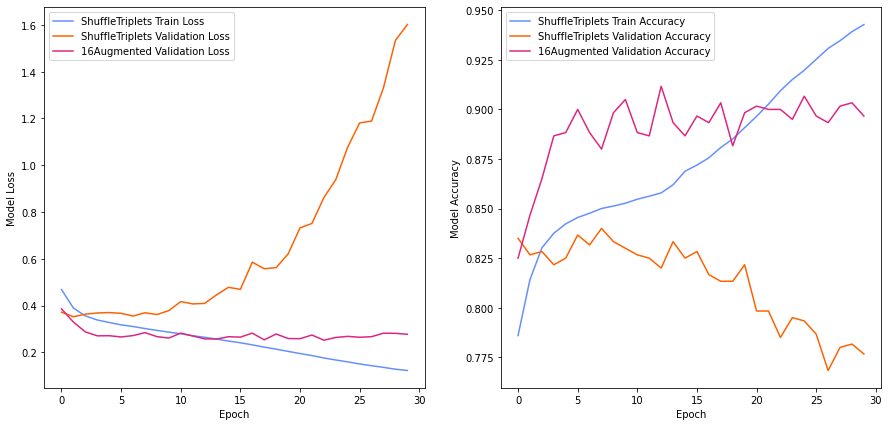

In [110]:
# evaluate model
score = model.evaluate(x_test15l, y_test, verbose=0)

# print performance
print('Final Test loss:', score[0])
print('Final Test accuracy:', score[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))


# summarize history for loss
ax1.plot(fit_allPerms.history['loss'], label = 'ShuffleTriplets Train Loss',color =  '#648FFF')
ax1.plot(fit_allPerms.history['val_loss'], label = 'ShuffleTriplets Validation Loss', color = '#FE6100')
ax1.plot(fit_augmented.history['val_loss'], label = '16Augmented Validation Loss', color  = '#DC267F' )

ax1.legend(loc = 'best')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Model Loss')


# summarize history for accuracy
ax2.plot(fit_allPerms.history['accuracy'], label = 'ShuffleTriplets Train Accuracy', color =  '#648FFF')
ax2.plot(fit_allPerms.history['val_accuracy'], label = 'ShuffleTriplets Validation Accuracy',color = '#FE6100')
ax2.plot(fit_augmented.history['val_accuracy'], label = '16Augmented Validation Accuracy', color  = '#DC267F')


ax2.legend(loc = 'best')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Model Accuracy')

plt.show()

As one can see the results are worse than the 16 bases data augmentation, probably due to the fact that the the rule was broken in the shuffling. Moreover, the network seems to overfit the data in last iterations.